<a href="https://colab.research.google.com/github/yinggg-o/barking-gecko-cafe/blob/main/gecko_cafe_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def read_data():
  return pd.read_csv("Weather historical Store - Observations.csv")

##Processing raw data

In [ ]:
def read_revenue():
    df = read_data()
    df = df[['Date','Barking Gecko Revenue']]

    return df

In [ ]:
read_data().tail()

,Date,Min ºC,Max ºC,Rainfall,Hot >35ºC,Cold <13ºC,Wet >10mm,School holidays,Public holidays,Weekends,Barking Gecko Revenue
412,17/8/2022,5.5,17.4,0.2,0,0,0,0,0,0,1646.91
413,18/8/2022,12.1,18.8,0.0,0,0,0,0,0,0,3030.60
414,19/8/2022,13.9,22.3,0.0,0,0,0,0,0,0,4054.90
415,20/8/2022,10.8,15.4,0.0,0,0,0,0,0,1,414.64
416,21/8/2022,10.0,NaN,5.6,0,1,0,0,0,1,1394.58


In [ ]:
def rainfall_date():
  df = read_data()
  df = df.loc[df['Rainfall'] >= 7]
  df = df['Date']

  return df

In [ ]:
def holiday_date():
  df = read_data()
  df = df.loc[df['School holidays'] == 1]
  df = df['Date']

  return df

#plots

In [ ]:
from matplotlib import pyplot as plt
def plot_year_sales():
  df = read_revenue()

  x = df['Date']
  y = df['Barking Gecko Revenue']

  plt.figure(figsize=(25,12))
  plt.xlabel('Date'), plt.ylabel('Sales')
  plt.plot(x, y, '-')

In [ ]:
def plot_features():
  geckoData = read_data()
  plot_cols = ['Weekends', 'Rainfall', 'School holidays', 'Barking Gecko Revenue']
  plot_features = geckoData[plot_cols]
  plot_features.index = geckoData.Date
  _ = plot_features.plot(subplots=True)

  plot_features = geckoData[plot_cols][:200]
  plot_features.index = geckoData[:200]
  _ = plot_features.plot(subplots=True)

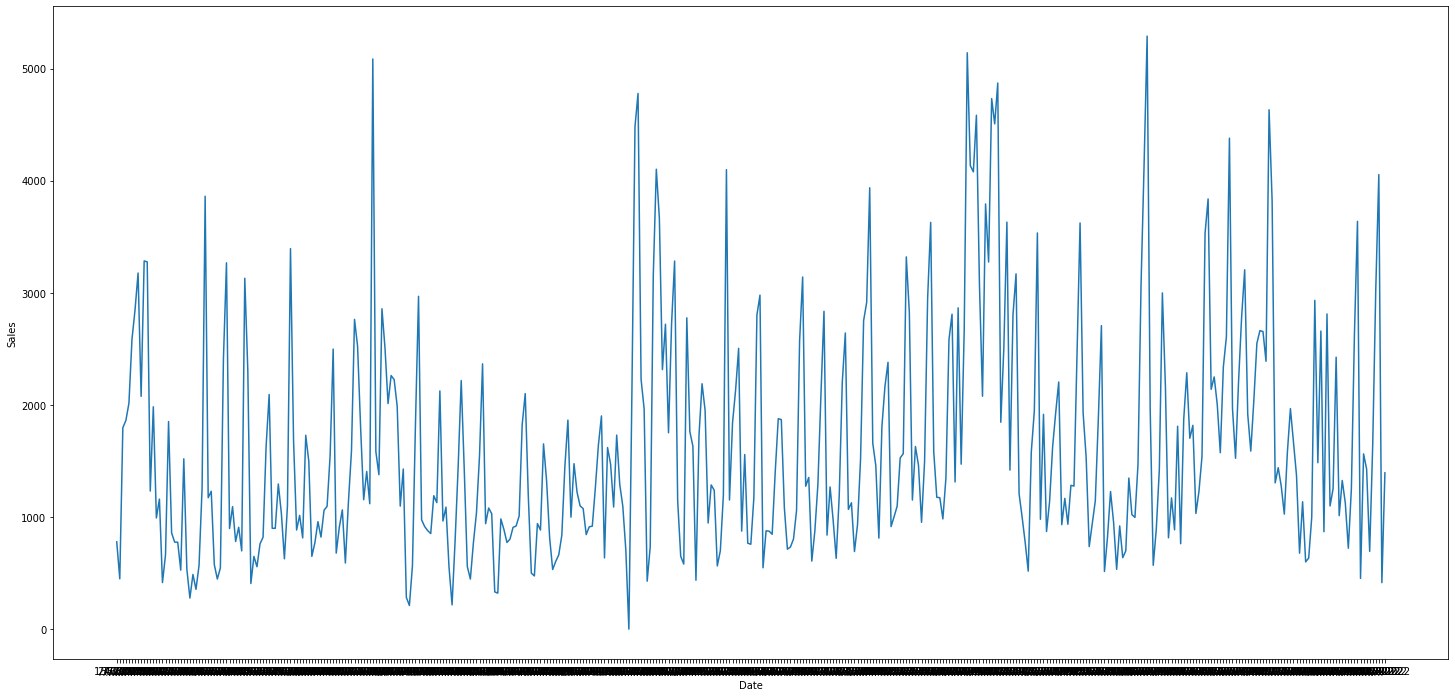

In [ ]:
plot_year_sales()

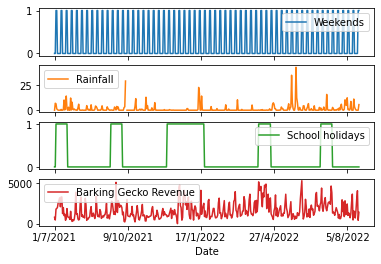

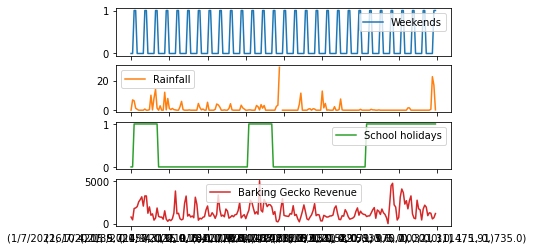

In [ ]:
plot_features()

#Data pre-processing
1. time and value for the model <br/> 
2. add 7 days lag regressor<br/> 
3. add historical rainfall and holiday events

In [ ]:
def data_for_model():
  df = read_revenue()
  #x and y
  df.columns = ['ds', 'y']
  df['ds'] = pd.to_datetime(df['ds'], dayfirst = True)
  #add lagged last week same day sales 
  #df['last_week_sale'] = df['y'].shift(7)

  return df

In [ ]:
data_for_model()

,ds,y
0,2021-07-01,779.04
1,2021-07-02,448.98
2,2021-07-03,1796.79
3,2021-07-04,1861.25
4,2021-07-05,2015.16
...,...,...
412,2022-08-17,1646.91
413,2022-08-18,3030.60
414,2022-08-19,4054.90
415,2022-08-20,414.64


In [ ]:
def add_events():

  """
  events considered to be 
  1. rainfall > 7
  2. school holiday
  """
  rainfall = pd.DataFrame(
      {
          "event": "Rainfall Days",
          "ds": pd.to_datetime(rainfall_date(), dayfirst = True) ,
      }
  )

  schoolholidays = pd.DataFrame(
      {
          "event": "School Holiday",
          "ds": pd.to_datetime(holiday_date(), dayfirst = True)
      }
  )
  history_events_df = pd.concat((rainfall, schoolholidays))
  return history_events_df

In [ ]:
add_events()

,event,ds
1,Rainfall Days,2021-07-02
13,Rainfall Days,2021-07-14
15,Rainfall Days,2021-07-16
16,Rainfall Days,2021-07-17
22,Rainfall Days,2021-07-23
...,...,...
375,School Holiday,2022-07-11
376,School Holiday,2022-07-12
377,School Holiday,2022-07-13
378,School Holiday,2022-07-14


#Neural Prophet package installing
For more details, please visit https://neuralprophet.com/contents.html

In [ ]:
 pip install neuralprophet[live]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 113 kB 16.2 MB/s 
     |████████████████████████████████| 706 kB 55.7 MB/s 
     |████████████████████████████████| 1.4 MB 54.3 MB/s 
     |████████████████████████████████| 419 kB 56.3 MB/s 
     |████████████████████████████████| 232 kB 78.7 MB/s 
     |████████████████████████████████| 51 kB 7.9 MB/s 
     |████████████████████████████████| 1.6 MB 48.5 MB/s 


#Build the nueral network model

In [ ]:
from neuralprophet import NeuralProphet

m = NeuralProphet(
    growth = "linear",
    n_changepoints = 30,
    trend_reg= 5,
    trend_reg_threshold = False,
    yearly_seasonality = "auto",
    weekly_seasonality = "auto",
    daily_seasonality = False,
    seasonality_mode = "additive",
    seasonality_reg = 1,
    n_lags = 7,
    batch_size = 32,
    num_hidden_layers = 2,
    d_hidden =16,
    epochs = 50,
    loss_func = "Huber",
    normalize = "auto",
    impute_missing = True,
    n_forecasts=7
)

#add lagged regressor the last week's sales
#m = m.add_lagged_regressor(names='last_week_sale')

#add public holidays of south australia
m = m.add_country_holidays("AU",mode="additive")

#add events to the model
m = m.add_events(["Rainfall Days", "School Holiday"])

df = m.create_df_with_events(data_for_model(), add_events())
df

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO:NP.config:Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO:NP.config:Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


,ds,y,Rainfall Days,School Holiday
0,2021-07-01,779.04,0.0,0.0
1,2021-07-02,448.98,1.0,0.0
2,2021-07-03,1796.79,0.0,1.0
3,2021-07-04,1861.25,0.0,1.0
4,2021-07-05,2015.16,0.0,1.0
...,...,...,...,...
412,2022-08-17,1646.91,0.0,0.0
413,2022-08-18,3030.60,0.0,0.0
414,2022-08-19,4054.90,0.0,0.0
415,2022-08-20,414.64,0.0,0.0


In [ ]:
df_train, df_test = m.split_df(df=df, freq="D", valid_p=0.1)

metrics_train = m.fit(df=df_train, freq="D")
metrics_test = m.test(df=df_test)
metrics_test

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.76% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.76% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.731% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.731% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe prov

Finding best initial lr:   0%|          | 0/216 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.077% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 98.077% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.0837559700012207     │
│       RegLoss_test        │    0.0418948270380497     │
└───────────────────────────┴───────────────────────────┘

,Loss_test,RegLoss_test
0,0.083756,0.041895


In [ ]:
test = df[:409]
test

,ds,y,Rainfall Days,School Holiday
0,2021-07-01,779.04,0.0,0.0
1,2021-07-02,448.98,1.0,0.0
2,2021-07-03,1796.79,0.0,1.0
3,2021-07-04,1861.25,0.0,1.0
4,2021-07-05,2015.16,0.0,1.0
...,...,...,...,...
404,2022-08-09,721.90,0.0,0.0
405,2022-08-10,1252.39,1.0,0.0
406,2022-08-11,2626.39,0.0,0.0
407,2022-08-12,3637.60,0.0,0.0


In [ ]:
forecast = m.predict(df)
df_fc = m.get_latest_forecast(forecast)


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.76% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.76% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.764% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.764% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


Predicting: 12it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


In [ ]:
df_fc

,ds,y,origin-0
0,2022-08-15,1427.80,365.253510
1,2022-08-16,694.10,156.643723
2,2022-08-17,1646.91,324.113861
3,2022-08-18,3030.60,1625.714478
4,2022-08-19,4054.90,1449.238159
5,2022-08-20,414.64,443.038147
6,2022-08-21,1394.58,600.657959


0    1.998374
1    3.098905
2    1.070700
3   -4.606392
4    2.132792
5    2.235741
6    0.435905
dtype: float64

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


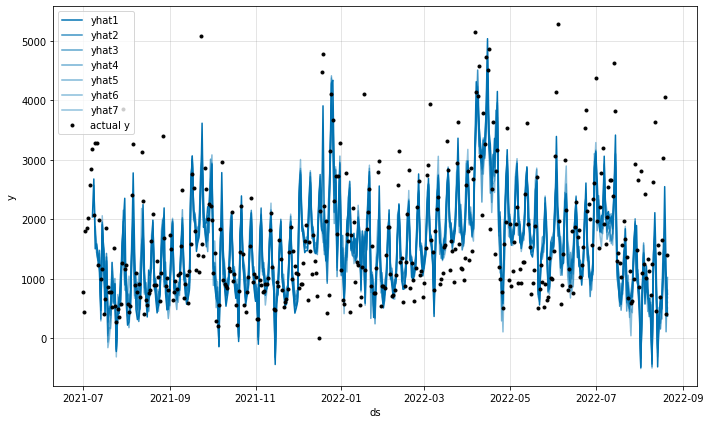

In [ ]:
fig1 = m.plot(forecast)